# Проектная работа

## Содержание

1. [Знакомство с данными](#1)
2. [Предобработка данных](#2)
3. [Обучение моделей](#3)
4. [Анализ результатов](#4)
5. [Общий вывод](#5)

## Описание проекта

Сервис по продаже автомобилей "Не бит, не крашен" разрабатывает новое приложение для привлечения новых клиентов. В нем можно быстро узнать рыночную стоимость своего автомобиля.

Необходимо построить модель для определения стоимости

Заказчку важны:

* качество предсказания;
* скорость предсказания;
* время обучения.

## Знакомство с данными <a id='1'></a> 

In [1]:
# импорт всех необходимых модулей для работы с данными
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# импорт всех модулей для работы с МашОбом
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

Для начала познакомимся с нашими данными:

In [3]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Из дополнительной информации известно:

* `DataCrawled` - дата скачивания анкеты из базы;
* `VehicleType` - тип автомобильного кузова;
* `RegistrationYear` - год регистрации автомобиля;
* `Gearbox` - тип коробки передач;
* `Power` - мощность (л.с.);
* `Model` - модель автомобиля;
* `Kilometer` - пробег (в км);
* `RegistrationMonth` - месяц регистрации автомобиля;
* `FuelType` - тип топлива; 
* `Brand` - марка автомобиля;
* `NotRepaired` - была машина в ремонте или нет;
* `DataCreated` - дата создания анекты;
* `NumberOfPictures` - количество фотографий автомобиля;
* `PostalCode` - почтовый индекс владельца анкеты;
* `LastSeen` - дата последней активности пользователя.

Целевой признак:

`Price` - цена (евро).

Видим, что у нас в данных есть пропуски. Посмотрим на их долю в датасете:

In [6]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Видим, что у нас есть пропуски в следующих признаках:

* `VehicleType` - доля пропусков составляет 10,5%;
* `Gearbox` - доля пропусков составляет 5,5%;
* `Model` - доля пропусков составляет 5,5%;
* `FuelType` - доля пропусков составляет 9,2%
* `NotRepeared` - доля пропусков составляет 20%

Теперь посмотрим на явные дубликаты: 

In [7]:
df.duplicated().sum()

4

In [8]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


**Вывод**:

Познакомились с историческими данными: техническими характеристиками и комплектациями автомобилей. Однако обнаружили проблемы, которые имеются в данных:

* Имеются пропуски в данных: в среднем доля пропусков составляет 10%. Необходимо выбрать наиболее подходящий способ обработки пропусков и избавиться от них;
* В данных имеются явные дубликаты. Необходимо от них избавиться несмотря на их малое количество - всего 4 наблюдения из ~350 тысяч;
* В данных имеются признаки, чей тип данных некорректнем. Необходимо разобраться о важности этих признаков для моделей обучения и если важны - привести к соответствующему типу.

В итоге, можно сказать, что на данном этапе данные не готовы для обучения моделей. Необходимо прозвести предобработку данных.

## Предобработка данных <a id='2'></a> 

###  Обработка дубликатов

Для начала избавимся от явных дубликатов:

In [9]:
df = df.drop_duplicates().reset_index(drop = True)

Убедимся в том, что дубликаты были удалены:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  NotRepaired        283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

Явные дубликаты удалены. Можно идти дальше.

### Обработка пропусков

Прежде всего, воспомним, в каких признаках у нас имеются пропуски и в каком процентном соотношении эти пропуски находятся в признаках:

* `VehicleType` - доля пропусков составляет 10,5%;
* `Gearbox` - доля пропусков составляет 5,5%;
* `Model` - доля пропусков составляет 5,5%;
* `FuelType` - доля пропусков составляет 9,2%
* `NotRepeared` - доля пропусков составляет 20%

Стоит сказать, что признаки, в которых имются пропуски в данном датасете относятся к категориальным переменным.

Видим, что для некоторых признаков имеется значение `other`, то есть остальные.

Посмотрим, есть ли наблюдения, в которых пропуски есть во всех признаках:

In [11]:
df_nan = df[(df.VehicleType.isna() == True) &
  (df.Gearbox.isna() == True) & 
  (df.Model.isna() == True) &
  (df.FuelType.isna() == True) &
  (df.NotRepaired.isna() == True)]
df_nan.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
100067,2016-03-25 13:58:10,0,NaN,2000,NaN,75,NaN,10000,0,NaN,audi,NaN,2016-03-25 00:00:00,0,12557,2016-03-25 14:41:44
244816,2016-03-07 15:38:35,2500,NaN,2007,NaN,0,NaN,150000,2,NaN,renault,NaN,2016-03-07 00:00:00,0,58453,2016-03-12 18:16:53
181477,2016-03-27 18:57:17,1500,NaN,2005,NaN,0,NaN,150000,0,NaN,mazda,NaN,2016-03-27 00:00:00,0,33334,2016-03-27 19:39:49
21212,2016-04-01 16:31:37,20,NaN,1990,NaN,0,NaN,150000,0,NaN,bmw,NaN,2016-04-01 00:00:00,0,65366,2016-04-07 10:16:03
150634,2016-03-23 22:53:12,0,NaN,2014,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-23 00:00:00,0,32361,2016-04-06 15:17:32


Видим, что наборы данных, в которых имеются пропуски во всех признаках представлены в виде объявлений-пустышек: никакой информации о характеристиках автомобиля: только пробег, марка, и сетевая активность пользователя. 

Будем считать эти пропуски связаны с человеческим фактором пользователей, которые не указали дополнительную информацию по своему автомобилю.

In [12]:
nans = df[(df.VehicleType.isna() == True) &
  (df.Gearbox.isna() == True) & 
  (df.Model.isna() == True) &
  (df.FuelType.isna() == True) &
  (df.NotRepaired.isna() == True)]['Price'].count()
nans

2237

Видим, что у нас есть 2237 наблюдений, в которых есть пропуски во всех признаках одновременно. 

Посчитаем долю этих пропусков ко всему объему датасета:

In [13]:
f'Доля пропусков: {(nans / len(df)):.3%}'

'Доля пропусков: 0.631%'

Видим, что доля пропусков составляет менее 1% от общего набора данных. Таким количеством наблюдений можно пожертвовать для обученияя моделей. Учитывая, что данные наблюдения мы посичтали как ошибку/незнание пользователя при заполнении объявления. Избавимся от этих пропусков.

In [14]:
df = df.drop(df_nan.index).reset_index(drop = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352128 entries, 0 to 352127
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        352128 non-null  object
 1   Price              352128 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   352128 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              352128 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          352128 non-null  int64 
 8   RegistrationMonth  352128 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              352128 non-null  object
 11  NotRepaired        283211 non-null  object
 12  DateCreated        352128 non-null  object
 13  NumberOfPictures   352128 non-null  int64 
 14  PostalCode         352128 non-null  int64 
 15  LastSeen           352128 non-null  object
dtypes: int64(7), object(

Пропуски, которые присутствовали во всех признаках одновременно, удалены. Продолжим обработку пропусков.

Посмотрим на количество упоминаний и уникальные значения в этих признаках, чтобы понять, как можно заполнить пропуски.

In [16]:
feature_nan = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
for elem in feature_nan:
    print(f'Unique values and quantity for {elem}:')
    print(df[elem].value_counts(), '\n')

Unique values and quantity for VehicleType:
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64 

Unique values and quantity for Gearbox:
manual    268249
auto       66283
Name: Gearbox, dtype: int64 

Unique values and quantity for Model:
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64 

Unique values and quantity for FuelType:
petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64 

Unique values and quantity for NotRepaired:
no     247158


Посмотрим на итоговое соотношение пропусков:

In [17]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          35253
RegistrationYear         0
Gearbox              17596
Power                    0
Model                17468
Kilometer                0
RegistrationMonth        0
FuelType             30658
Brand                    0
NotRepaired          68917
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**NotRepaired**

Для начала рассмотрим признак `NotRepaired`. Он имеет всего два возможных значения: Да/Нет. Пропусков cлишком много, чтобы просто избавиться от них. Предположим, что эти пропуски связаны с тем, что пользователи не указали состояние автомобиля по статусу ремонта, так как их автомобиль не был ремонте - просто решили не указывать этот пункт при создании объявления.

Поэтому заполним пропуски в этом признаке как "машина не была в ремонте". А затем преобразуем этот признак из строкового типа в булевый неявного типа:

* 0 - машина была в ремонте ('no');
* 1 - машина не была в ремонте ('yes').

In [18]:
df.loc[df.NotRepaired.isna() == True, 'NotRepaired'] = 'yes'

Проверим корректность заполнения пропусков в этом столбце:

In [19]:
df.NotRepaired.value_counts()

no     247158
yes    104970
Name: NotRepaired, dtype: int64

Пропуски заполнены, теперь преобразуем этот тип данных в более корректный тип:

In [20]:
dict_nan = {'yes':1,
           'no': 0}

In [21]:
df.NotRepaired = df.NotRepaired.map(dict_nan)

In [22]:
df.NotRepaired.value_counts()

0    247158
1    104970
Name: NotRepaired, dtype: int64

Пропуски в этом признаке заполнены и приведены к соответствующему типу.

**Model**

Пропуски в данном признаке заполнить трудно, так как нельзя по имеющимся данным восстановить истинное значение в этом столбце. Удалить пропуски можно, но таким образом можем потерять значимое количество данных для прогноза. Однако в этом признаке есть поле `other`- в контексте продаж автомобиля это могут быть малоизвестные компании по производству автомобилей и их модели, названия которых, нет в базе данных сервиса по продаже автомобилей.

Возможная причина пропуска: пользователь не нашел из предложенных сервисом вариантов и оставил как есть.

Поэтому с целью сохранения данных заполним пропуски по этому признаку значением `other`.

In [23]:
df.loc[df.Model.isna() == True, 'Model'] = 'other'

Убедимся в том, что пропуски заполнены:

In [24]:
df.Model.isna().sum()

0

Пропуски по признаку `Model` устранены, продолжим дальше.

**FuelType**

Здесь мы видим аналогичную ситуацию с признаком `Model`: скорее всего, пользователи не знают, какой тип топлива используется для автомобиля. Поэтому все пропуски в этом признаке обозначим как `other` - что-то, чего нет в базе данных сервиса и чего не знает пользователь.

In [25]:
df.loc[df.FuelType.isna() == True, 'FuelType'] = 'other'

Убедимся, что пропуски заполнены:

In [26]:
df.FuelType.isna().sum()

0

Пропуски заполнены. Рассмотрим оставшиеся признаки.

**VehicleType**

Аналогичный метод применим для признака `VehicleType` - заменим пропуски на `other`:

In [27]:
df.loc[df.VehicleType.isna() == True, 'VehicleType'] = 'other'

Убедимся, что пропуски заполнены:

In [28]:
df.VehicleType.isna().sum()

0

Рассмотрим оставшийся признак.

**Gearbox**

По данному признаку у нас имеется всего два возможных значения: автоматическая и механическая коробки передач. С одной стороны, количество пропусков по этому признаку составляет 5% от общего набора данных. С другой - такое количество пропусков в данном признаке - достаточно большое значение для того, чтобы их удалить. Можно реализовать категорию `unknown` - так мы укажем пользователей, которые забыли указать тип коробки передач. Так мы не потеряем данные.

In [29]:
df.loc[df.Gearbox.isna() == True, 'Gearbox'] = 'unknown'

Проверим, остались ли пропуски в данном признаке:

In [30]:
df.Gearbox.isna().sum()

0

In [31]:
df.isna().mean()

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

Все пропуски были устранены. Продолжим предобработку данных.

### Поиск аномальных значений

Посмотрим на столбец `Power`. Он показыввает мощность автомобиля, представленную в лошадиных силах.

In [32]:
df.Power.value_counts()

0       38204
75      24000
60      15881
150     14584
101     13292
        ...  
645         1
525         1
1922        1
6018        1
902         1
Name: Power, Length: 712, dtype: int64

Видим, что у нас есть аномально большие значения (больше 5 тысяч л.с.). Посмотрим на диаграмму размаха

In [33]:
def boxplot(df: pd.DataFrame, 
           name: str):
    df.boxplot(name, figsize=(20,10))
    plt.ylim(-150, 1000)
    plt.title('Диаграмма размаха для ' + name)
    plt.ylabel(name);

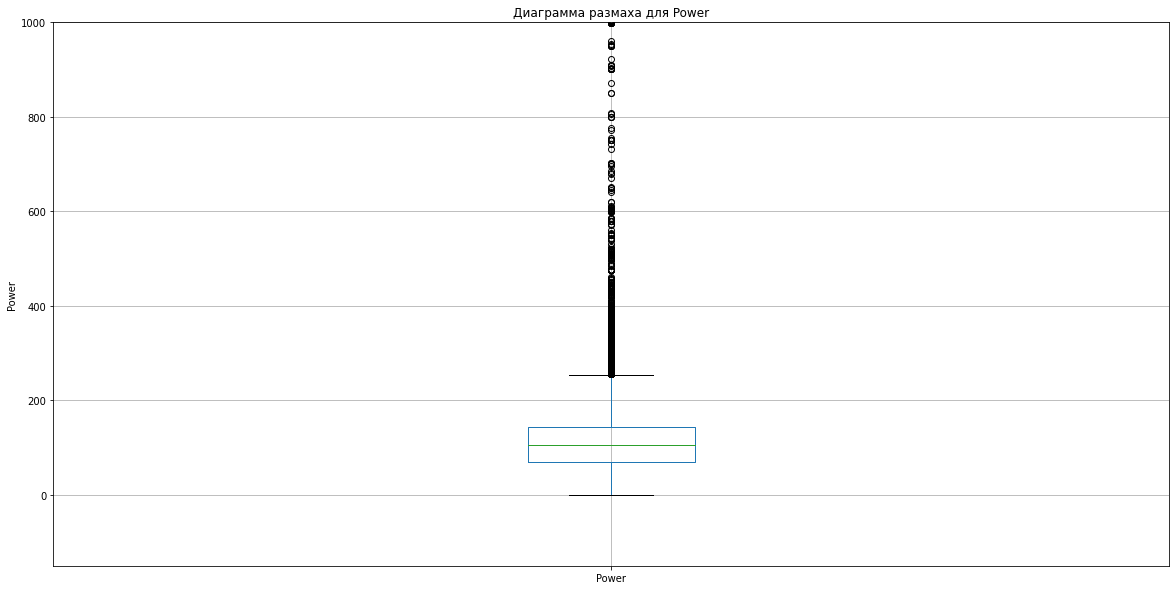

In [34]:
boxplot(df, 'Power')

Имеются нереалистичные аномальные значения по признаку `Power`. Из дополнительной информации узнали, что макисмальная предельная мощность на данный момент составляет 1200 л.с. Для более корректного прогноза стоимости цены автомобиля отфильтруем данные до адекватного (хотя бы реалистичного) порога (до 1200 л.с.)

In [35]:
df = df[df.Power < 1200].reset_index(drop = True)

Данные по мощности отфильтрованы. Рассмотрим другие количественные признаки.

In [36]:
df = df[df.Power > 0].reset_index(drop = True)

Рассмотрим столбец `Price`.

In [37]:
df.Price.value_counts()

0        6849
1500     4642
500      4596
1200     3928
2500     3842
         ... 
17047       1
415         1
5688        1
1811        1
8188        1
Name: Price, Length: 3622, dtype: int64

Имеются нулевые значения стоимости. Рассмотрим на диаграмму размаха по этому признаку.

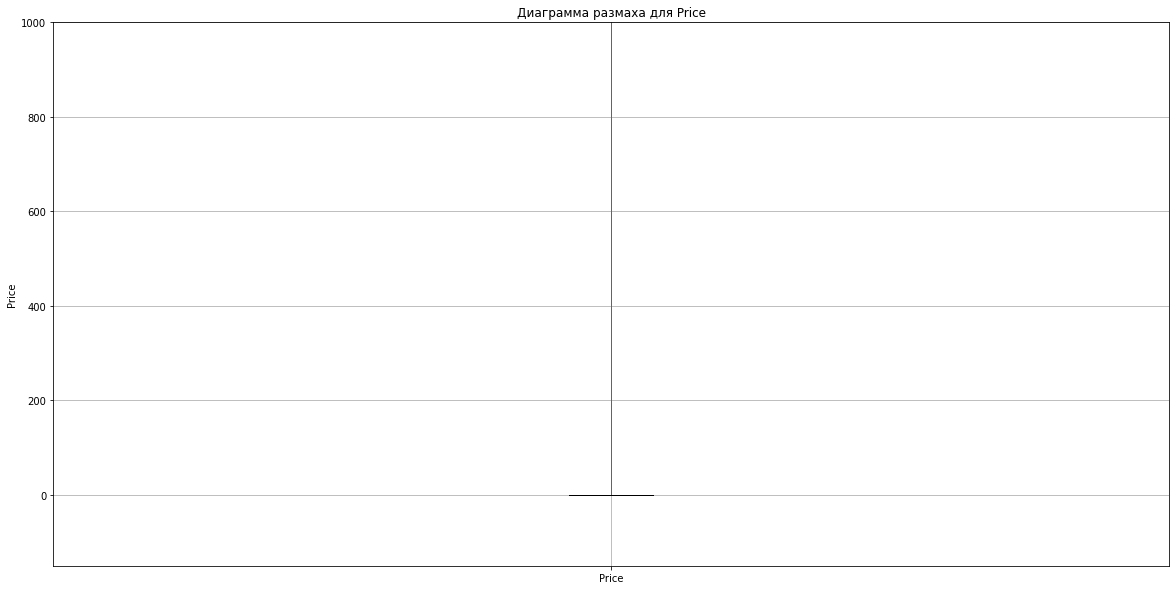

In [38]:
boxplot(df, 'Price')

По диаграмме размаха цены автомобилей имеются нулевые значения. Такое может быть связано с ошибкой пользователя при выставлении объявлении о продаже автомобиля. Избавимся от всех аномально низких значений. Выберем все наблюдения, где стоимость объекта больше 100 евро.

In [39]:
df = df[df.Price >= 100].reset_index(drop = True)

Теперь посмотрим на признак `RegistrationYear`. Посмотрим на уникальные значения:

In [40]:
df.sort_values('RegistrationYear')['RegistrationYear'].unique()

array([1000, 1500, 1800, 1910, 1923, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2800, 2900, 4000, 4500,
       4800, 5000, 5911, 6000, 8200])

Видим, что у нас есть нереальные значения года регистрации автомобиля. Выберем только те объявления, где год выпуска у нас меньше 2022 и больше 1910 года.

In [41]:
df = df[(df.RegistrationYear >= 1910) & (df.RegistrationYear <= 2022)].reset_index(drop = True)

Признак офильтрован. Продолжим предобработку данных.

In [42]:
max_year = pd.to_datetime(df.DateCrawled, format = '%Y-%m-%d %H:%M:%S').dt.year.max()

In [43]:
df = df[df.RegistrationYear <= max_year]

### Выбор важных признаков

Для моделей машинного обучения важно выбрать наиболее подходящие для обучения признаки. 

Мы предсказываем признак: цена.

Для обучения модели уберем малозначимые (лишние) признаки:

* `DataCrawled` - дата скачивания анкеты из базы; 
* `DateCreated` - дата создания анкеты;
* `NumberOfPictures` - количество фотографий автомобиля;
* `PostalCode` - почтовый индекс владельца анкеты;
* `LastSeen` - дата последней активности пользователя.

In [46]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis = 1)

Проверим, что все признаки удалены:

In [47]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

После того, как выбрали важные признаки. Выберем подходящие модели для обучения:

* Простые модели обучения:
    * Линейная регрессия;
    * Случайный лес.
* Модели, в основе которого используется градиентный бустинг:
    * CatBoost
    * LightGBM
    * XGBoost

В зависимости от того, какие модели будем применять, необходимо учесть кодирование категориальных признаков. Например, для моделей CatBoost и LightGBM кодирование признаков не нужно проводить. Данные инструменты предобработки данных уже включены в эти пакеты.

Более того, необходимо провести масштабирование признаков для ускорения сходимости алгоритма.

То есть, сделаем два идентичных датафрейма:
1. Датафрейм без кодирования признаков: он пригодится для отдельных алгоритмов машинного обучения;
2. Датафрейм, где категориальные признаки закодированы с помощью метода One-Hot encoding. Этот набор данных пригодится для простых регрессоров.

In [48]:
df_no_encoding = df.copy()

In [49]:
df = pd.get_dummies(df, drop_first=True)

In [50]:
df.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
0,18300,2011,190,125000,5,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9800,2004,163,125000,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1500,2001,75,150000,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3600,2008,69,90000,7,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,650,1995,102,150000,10,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Масштабирование признаков будет проводиться в процессе обучения модели, чтобы избежать эффекта подглядывания.

**Вывод**:

В процессе предобработки данных устранили следующие проблемы:

* Устранили все пропуски в данных: незначительную часть удалили, посчитав эти данные за пустышки, часть заполнили нестандартным значением;
* Избавились от явных дубликатов в данных;
* Избавились от аномальных значений в признаках
* Сформировали два датафрейма: первый - без прямого кодирования данных, второй - с применением кодирования категориальных признаков.

После того, как подготовили данные приступим к обучению модели.

## Обучение моделей <a id='3'></a> 

После того, как провели предобработку данных, реализуем обучение моделей. Для этого реализуем несколько классов:

* Класс-предок: с помощью него будем инициализировать и предобрабатывать параметры моделей;
* Класс моделей, для которых обязательно реализовывать кодирование категориальных признаков:
    * Линейная регрессия;
    * Случайный лес;
    * Дерево решений.
* Класс моделей, для который кодирование категориальных признаков необязательно:
    * CatBosstRegressor
    * LGBRegressor
    
Наилучшие гиперпараметры и результаты будем выбирать с помощью пятикратной кросс-валидации с помощью грубого поиска.

In [51]:
# Класс-инициализатор. С помощью него мы формируем обучающую, тестовую выборки. 
# Дополнительно масштабируем признаки - лишним не будет
class features:
    def __init__(self, df:pd.DataFrame):
        self.df = df
    def generate_features(self, name: str):
        self.train, self.test = train_test_split(self.df, 
                                                 test_size = 0.3,
                                                 random_state = 54321)
        
        self.train_feature = self.train.drop(name, axis = 1)
        self.train_target = self.train[name]
        
        self.test_feature = self.test.drop(name, axis = 1)
        self.test_target = self.test[name]
        
    def __str__(self):
        return f'''train_feature:{self.train_feature.shape} 
        \ntest_feature:{self.test_feature.shape} 
        \ntrain_target:{self.train_target.shape} 
        \ntest_target:{self.test_target.shape}'''
        
    def scaler_features(self):
        
        numeric = ['Power', 'RegistrationYear', 
                   'Kilometer', 'RegistrationMonth']
        
        scaler = StandardScaler()
        scaler.fit(self.train_feature[numeric])
        
        self.train_feature[numeric] = scaler.transform(self.train_feature[numeric])
        self.test_feature[numeric] = scaler.transform(self.test_feature[numeric])
        
        return self.train_feature, self.test_feature
    
# Класс моделей, для которых необходима обработка категориальных признаков с помощью кодирования
# этот класс - дочерний, наследует инициализированные признаки и целевой признаки
# которые стандартизированы  
class models_for_encoding(features):

    def __init__(self, df, name):
        features.__init__(self, df)
        features.generate_features(self, name)
        self.train_features, self.test_features =  features.scaler_features(self)

    def LR_model(self):
        self.model = LinearRegression()
        self.scores = cross_val_score(self.model, 
                                      self.train_features,
                                      self.train_target,
                                      scoring = 'neg_root_mean_squared_error',
                                      cv = 5, 
                                      n_jobs = 4)
        print(f'The RMSE score of Linear Regression is: {self.scores.mean()}')
    
    def RF_model(self):
        params = {'max_depth': range(10, 51, 10),
                  'n_estimators': range(1, 7, 2)}
        model = RandomForestRegressor(random_state = 54321)
        self.grid_model = GridSearchCV(model, 
                                       params, 
                                       scoring='neg_root_mean_squared_error',
                                       cv = 5,
                                       n_jobs = 4,
                                       verbose = 10)
        self.grid_model.fit(self.train_features, self.train_target)
        print(f'The best score of RF is: {self.grid_model.best_score_}')
        return self.grid_model.best_estimator_

    def DT_model(self):
        params = {'max_depth': range(10,81,10)}
        model = DecisionTreeRegressor(random_state = 54321)
        self.grid_model = GridSearchCV(model, 
                                       params, 
                                       scoring='neg_root_mean_squared_error',
                                       cv = 5,
                                       n_jobs = 4,
                                       verbose = 10)
        self.grid_model.fit(self.train_features, self.train_target)
        print(f'The best score of DT is: {self.grid_model.best_score_}')
        return self.grid_model.best_estimator_

# класс моделей, которым не нужна процедура прямого кодирования данных
# catboost
# lightGBM
class models_without_encoding(features):
    
    def __init__(self, df, name):
        features.__init__(self, df)
        features.generate_features(self, name)
        self.train_features, self.test_features = features.scaler_features(self)
        self.cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']


    def CAT_model(self):

        params = {'iterations': range(5, 17, 2),
                  'depth': range(10, 16, 2)}

        model = CatBoostRegressor(cat_features = self.cat_columns,
                                  learning_rate=.5, 
                                  thread_count = 4,
                                  loss_function = 'RMSE',
                                  random_state=54321);

        self.grid = GridSearchCV(model, 
                                params, 
                                scoring='neg_root_mean_squared_error',
                                cv = 5,
                                verbose = 10)
        self.grid.fit(self.train_features, self.train_target);
        print(f'The best score of CB is: {self.grid.best_score_}')
        return self.grid.best_estimator_
    
    def light_model(self):
        
        for col_name in self.cat_columns:
            self.train_features[col_name] = self.train_features[col_name].astype('category')
            self.test_features[col_name] = self.test_features[col_name].astype('category')
            
        model = LGBMRegressor(learning_rate = .5, 
                              random_state = 54321,
                              n_jobs = 4)
        
        params = {'max_depth': range(10, 21,5),
                 'n_estimators': range(10, 51, 10),
                 'num_leaves': range(20, 101, 20)}
        
        self.grid = GridSearchCV(model,
                                params,
                                scoring = 'neg_root_mean_squared_error',
                                cv = 5,
                                verbose = 10)
        
        self.grid.fit(self.train_features, self.train_target);
        print(f'The best score of LGBM is: {self.grid.best_score_}')
        return self.grid.best_estimator_
        

**Модели, для которых используем заранее закодированные признаки**

In [52]:
no_enc_m = models_for_encoding(df, 'Price')

**Линейная регрессия**

In [53]:
%%time
no_enc_m.LR_model()

The RMSE score of Linear Regression is: -2640.1453222483815
CPU times: user 72.2 ms, sys: 181 ms, total: 253 ms
Wall time: 39.4 s


**Случайный лес**

In [54]:
%%time
model_RF = no_enc_m.RF_model()

Fitting 5 folds for each of 15 candidates, totalling 75 fits
The best score of RF is: -1708.1274077248643
CPU times: user 19.3 s, sys: 455 ms, total: 19.8 s
Wall time: 16min 11s


**Дерево решений**

In [55]:
%%time
model_DT = no_enc_m.DT_model()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
The best score of DT is: -1947.3649178848834
CPU times: user 6.07 s, sys: 323 ms, total: 6.39 s
Wall time: 4min 46s


По результатам тестирования обучения моделей на пятикратной кросс-валидации видим, что лучшая точность у модели случайного леса за счет более гибкой настройки гиперапараметров и участия ансамбля деревьев. Однако перебор гиперпараметров нужно выбирать так, чтобы модель обучалась не слишком долго, сохранив приемлемые значения метрики качества обучения модели. 

Самая быстрая модель - модель линейной регрессии, но при этом ее точность самая худшая среди всех из заданного класса моделей.

Дерево решений - золотая середина по времени и качеству обучения.

Теперь перейдем к классу моделей, для которых кодирование категориальных признаков необязательно.

**Модели, для которых не применяли кодирование признаков заранее**

In [56]:
enc_m = models_without_encoding(df_no_encoding, 'Price')

**CatBoostRegressor**

In [57]:
%%time
CAT_model = enc_m.CAT_model();

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START depth=10, iterations=5.....................................
0:	learn: 3131.1839884	total: 103ms	remaining: 410ms
1:	learn: 2448.0353111	total: 296ms	remaining: 445ms
2:	learn: 2137.0342927	total: 494ms	remaining: 329ms
3:	learn: 2001.6887074	total: 686ms	remaining: 172ms
4:	learn: 1907.4741009	total: 873ms	remaining: 0us
[CV 1/5; 1/18] END ...................depth=10, iterations=5; total time=   2.1s
[CV 2/5; 1/18] START depth=10, iterations=5.....................................
0:	learn: 3120.8402138	total: 70.5ms	remaining: 282ms
1:	learn: 2451.3569402	total: 268ms	remaining: 401ms
2:	learn: 2130.0159080	total: 463ms	remaining: 309ms
3:	learn: 1959.4608349	total: 657ms	remaining: 164ms
4:	learn: 1884.1888420	total: 849ms	remaining: 0us
[CV 2/5; 1/18] END ...................depth=10, iterations=5; total time=   1.9s
[CV 3/5; 1/18] START depth=10, iterations=5.....................................
0:	lear

**LGBMRegressor**

In [58]:
%%time
light_model = enc_m.light_model()

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5; 1/75] START max_depth=10, n_estimators=10, num_leaves=20...............
[CV 1/5; 1/75] END max_depth=10, n_estimators=10, num_leaves=20; total time=   0.6s
[CV 2/5; 1/75] START max_depth=10, n_estimators=10, num_leaves=20...............
[CV 2/5; 1/75] END max_depth=10, n_estimators=10, num_leaves=20; total time=   0.7s
[CV 3/5; 1/75] START max_depth=10, n_estimators=10, num_leaves=20...............
[CV 3/5; 1/75] END max_depth=10, n_estimators=10, num_leaves=20; total time=   0.5s
[CV 4/5; 1/75] START max_depth=10, n_estimators=10, num_leaves=20...............
[CV 4/5; 1/75] END max_depth=10, n_estimators=10, num_leaves=20; total time=   0.5s
[CV 5/5; 1/75] START max_depth=10, n_estimators=10, num_leaves=20...............
[CV 5/5; 1/75] END max_depth=10, n_estimators=10, num_leaves=20; total time=   0.5s
[CV 1/5; 2/75] START max_depth=10, n_estimators=10, num_leaves=40...............
[CV 1/5; 2/75] END max_depth=10,

В результате обучения моделей и проверки качества на пятикратной кросс-валидации увидели, что LGBMRegressor - лучшая модель из всех представленных. Общее время обучения и предсказания составило почти 3 минуты, однако качество - лучшее среди всех представленных в проекте моделей!

## Анализ результатов <a id='4'></a> 

Прежде чем сделаем анализ результатов обучения, проведем проверку моделей на тестовой выборке. 

А затем сформируем итоговую таблицу по поолученным данным.

In [59]:
def take_time(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        res = func(*args, **kwargs)
        stop = time.time()
        print(f'Время обучения и предсказания модели: {stop - start:.3f} секунд')
    return wrapper

In [60]:
## Сорри, что так плохо написал, но просто идей у меня не было))
# Наверное, следует добавить этот метод вместе с декоратором внутрь каждого класса и пусть считает
@take_time
def fit_predict(
                type_m = 'no_enc',
                model = LinearRegression()):
    
    if type_m == 'no_enc':
        model.fit(no_enc_m.train_features, no_enc_m.train_target)
        prediction = model.predict(no_enc_m.test_features)
        print(f'RMSE score: {mean_squared_error(no_enc_m.test_target, prediction, squared=False)}')
    else:
        model.fit(enc_m.train_features, enc_m.train_target)
        prediction = model.predict(enc_m.test_features)
        print(f'RMSE score: {mean_squared_error(enc_m.test_target, prediction, squared=False)}')

**Линейная регрессия**

In [ ]:
fit_predict()

**Случайный лес**

In [ ]:
fit_predict(model = model_RF)

**Решающее дерево**

In [ ]:
fit_predict(model = model_DT)

**CatBoostRegressor**

In [ ]:
fit_predict(type_m = 'enc',  model = CAT_model)

**LGBMRegressor**

In [ ]:
fit_predict(type_m = 'enc', model = light_model)

В результате получили следующие результаты:

|**Выборка**|**Модель**|**Время (обучение + предсказание)**|**Значение метрики RMSE**|
|:---------:|:--------:|:---------------------------------:|:-----------------------:|
|**Обучающая выборка**|Линейная регрессия|37.1 сек.|2737.558|
||Случайный лес|9 мин. 43 сек.|1768.643|
||Решающее дерево|2 мин. 18 сек.|2023.397|
||CatBoostRegressor|5 мин. 43 сек.|1738.891|
||LGBMRegressor|3 мин. 42 сек.|1668.475|
|**Тестовая выборка**|Линейная регрессия|4.82 сек.|2741.919|
||Случайный лес|32.63 сек.|1752.052|
||Решающее дерево|9.98 сек.|1990.872|
||CatBoostRegressor|8 сек.|1738.92|
||LGBMRegressor|1.1 сек.|1652.756|

По результатам исследования получили следующие результаты:
* Для обучающей выборки: 
    * Самая быстрая модель: модель линейной регрессии;
    * Модель с лучшей метрикой качества обучения: LGBMRegressor;
    * Самая медленная модель: модель Случайного леса;
    * Модель с худшей метрикой качества обучения: модель линейной регрессии.
* Для тестовой выборки:
    * Самая быстрая модель: LGBMRegressor;
    * Модель с лучшей метрикой качества обучения: LGBMRegressor;
    * Самая медленная модель: модель случайного леса;
    * Модель с худшей метрикой качества обучения: модель линейной регрессии.
    
Исходя из полученных результатов можем сказать, что наиболее подходящая модель для решения задачи заказчика является **LGBMRegressor**

## Общий вывод <a id='5'></a> 

Была дана задача: 
>Сервис по продаже автомобилей "Не бит, не крашен" разрабатывает новое приложение для привлечения новых клиентов. В нем можно быстро узнать рыночную стоимость своего автомобиля.

>Необходимо построить модель для определения стоимости

Для решения задачи заказчик предоставил исторический набор данных по выставленным позициям на своем сервисе. В результате знакомства с данным обнаружили ряд проблем:
* имеются значительные пропуски в данных;
* имеются явные дубликаты в данных;
* тип данных некоторых признаков представлен некорректно;
* имеются лишние для обучения признаки.

После которых решили, что набор данных для решения задачи заказчика не готов - необходимо провести предобработку данных.

После предобработки данных приступили к обучению моделей. Для которых заранее сделали следующее:
* Разбивка на обучающую и тестовую выборки в соотношении 70:30;
* Сделали масштабирование количественных признаков;
* Реализовали процедуру прямого кодирования для категориальных признаков;
* Использовали пятикратную кросс-валидацию на обучающей выборке;
* Провели контрольное тестирование на тестовой выборке.

В результате исследования получили следующие результаты:

* **Для обучающей выборки**: 
    * Самая быстрая модель: модель линейной регрессии;
    * Модель с лучшей метрикой качества обучения: LGBMRegressor;
    * Самая медленная модель: модель Случайного леса;
    * Модель с худшей метрикой качества обучения: модель линейной регрессии.
* **Для тестовой выборки**:
    * Самая быстрая модель: LGBMRegressor;
    * Модель с лучшей метрикой качества обучения: LGBMRegressor;
    * Самая медленная модель: модель случайного леса;
    * Модель с худшей метрикой качества обучения: модель линейной регрессии.
    
Исходя из полученных результатов можем сказать, что наиболее подходящая модель для решения задачи заказчика является **LGBMRegressor**